In [317]:
from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.markers as markers
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine
from datetime import datetime

dotenv_local_path = '.env'
load_dotenv(dotenv_path=dotenv_local_path, verbose=True)

True

## Socrata API

In [20]:
client=Socrata(
"data.cityofnewyork.us",
os.environ.get("NYC_token"),
username=os.environ.get("NYC_username"),
password=os.environ.get("NYC_password")
)

## MySQL

In [2]:
engine = create_engine('mysql+pymysql://' + os.environ.get("MYSQL_USER") + ":" + os.environ.get("MYSQL_PASSWORD") + '@localhost:3306/nyc_crime')

In [22]:
#engine.execute("DROP TABLE IF EXISTS arrests;")

In [23]:
engine.execute(
"""
CREATE TABLE IF NOT EXISTS arrests (
arrest_key bigint not null primary key,
arrest_date date,
pd_cd int,
pd_desc varchar(250),
ky_cd int,
ofns_desc varchar(250),
law_code varchar(250),
law_cat_cd varchar(250),
arrest_boro varchar(250),
arrest_precinct int,
jurisdiction_code int,
age_group varchar(250),
perp_sex varchar(250),
perp_race varchar(250),
x_coord_cd varchar(250),
y_coord_cd varchar(250),
latitude numeric(15,10),
longitude numeric(15,10)
);
"""
)

In [24]:
#start_year=2006
#end_year=2019

for i in range(start_year, end_year+1, 1):
    
    results = client.get("8h9b-rp9u", where="arrest_date between "+"'"+str(i)+"-01-01'"+" and "+"'"+str(i)+"-12-31'", limit=10000000)
    results_df = pd.DataFrame.from_records(results)
    
    results_df = results_df.drop('lon_lat',1)

    results_df['arrest_key'] = results_df['arrest_key'].str.strip()
    results_df = results_df.drop(results_df[results_df['arrest_key'] == 'UNKNOWN'].index)
    results_df['arrest_key'] = results_df['arrest_key'].astype(int)
    
    results_df['arrest_date'] = results_df['arrest_date'].str.strip()
    results_df['arrest_date'] = results_df['arrest_date'].astype(str)
    results_df['arrest_date'] = results_df['arrest_date'].str.slice(0,10)
    
    results_df['pd_cd'] = results_df['pd_cd'].str.strip()
    results_df['pd_cd'] = results_df['pd_cd'].str.replace('NULL', '0')
    results_df['pd_cd'] = results_df['pd_cd'].str.replace('UNKNOWN', '0')
    results_df['pd_cd'] = results_df['pd_cd'].fillna('0')
    results_df['pd_cd'] = results_df['pd_cd'].astype(float)
    results_df['pd_cd'] = results_df['pd_cd'].astype(int)
    
    results_df['pd_desc'] = results_df['pd_desc'].str.strip()
    results_df['pd_desc'] = results_df['pd_desc'].str.replace('NULL', 'UNKNOWN')
    results_df['pd_desc'] = results_df['pd_desc'].fillna('UNKNOWN')
    
    results_df['ky_cd'] = results_df['ky_cd'].str.strip()
    results_df['ky_cd'] = results_df['ky_cd'].str.replace('NULL', '0')
    results_df['ky_cd'] = results_df['ky_cd'].fillna('0')
    results_df['ky_cd'] = results_df['ky_cd'].astype(float)
    results_df['ky_cd'] = results_df['ky_cd'].astype(int)  
    
    results_df['ofns_desc'] = results_df['ofns_desc'].str.strip()
    results_df['ofns_desc'] = results_df['ofns_desc'].str.replace('NULL', 'UNKNOWN')
    results_df['ofns_desc'] = results_df['ofns_desc'].fillna('UNKNOWN')
    
    results_df['law_code'] = results_df['law_code'].str.strip()
    results_df['law_code'] = results_df['law_code'].str.replace('NULL', 'UNKNOWN')
    results_df['law_code'] = results_df['law_code'].fillna('UNKNOWN')
    
    results_df['law_cat_cd'] = results_df['law_cat_cd'].str.strip()
    results_df['law_cat_cd'] = results_df['law_cat_cd'].str.replace('NULL', 'UNKNOWN')
    results_df['law_cat_cd'] = results_df['law_cat_cd'].fillna('UNKNOWN')
    
    results_df['arrest_boro'] = results_df['arrest_boro'].str.strip()
    
    results_df['arrest_precinct'] = results_df['arrest_precinct'].str.strip()
    results_df['arrest_precinct'] = results_df['arrest_precinct'].astype(float)
    results_df['arrest_precinct'] = results_df['arrest_precinct'].astype(int)
    
    results_df['jurisdiction_code'] = results_df['jurisdiction_code'].str.strip()
    results_df['jurisdiction_code'] = results_df['jurisdiction_code'].str.replace('NULL', '0')
    results_df['jurisdiction_code'] = results_df['jurisdiction_code'].fillna('0')
    results_df['jurisdiction_code'] = results_df['jurisdiction_code'].astype(float)
    results_df['jurisdiction_code'] = results_df['jurisdiction_code'].astype(int)
    
    results_df['age_group'] = results_df['age_group'].str.strip()
    good_ages = ['<18', '18-24', '25-44', '45-64', '65+']
    results_df.loc[~results_df.age_group.isin(good_ages), 'age_group'] = 'UNKNOWN'
    
    results_df['perp_sex'] = results_df['perp_sex'].str.strip()
    results_df['perp_race'] = results_df['perp_race'].str.strip()
    
    results_df['x_coord_cd'] = results_df['x_coord_cd'].str.strip()
    #results_df['x_coord_cd'] = results_df['x_coord_cd'].astype(float)
    #results_df['x_coord_cd'] = results_df['x_coord_cd'].astype(int)
    
    results_df['y_coord_cd'] = results_df['y_coord_cd'].str.strip()
    #results_df['y_coord_cd'] = results_df['y_coord_cd'].astype(float)
    #results_df['y_coord_cd'] = results_df['y_coord_cd'].astype(int)
    
    results_df['latitude'] = results_df['latitude'].str.strip()
    results_df['latitude'] = results_df['latitude'].astype(float)
    
    results_df['longitude'] = results_df['longitude'].str.strip()
    results_df['longitude'] = results_df['longitude'].astype(float)   
    
    results_df.to_sql('arrests_temp', con=engine, index=False, if_exists='replace', chunksize=10000)
    
    engine.execute("""
    UPDATE arrests 
    LEFT JOIN arrests_temp 
    ON arrests.arrest_key = arrests_temp.arrest_key 
    SET arrests.arrest_key = arrests_temp.arrest_key 
    WHERE arrests.arrest_key != arrests_temp.arrest_key;
    """)
    
    engine.execute("""
    INSERT INTO arrests (arrest_key, arrest_date, pd_cd, pd_desc, ky_cd, ofns_desc, law_code, 
    law_cat_cd, arrest_boro, arrest_precinct, jurisdiction_code, age_group, perp_sex, perp_race, 
    x_coord_cd, y_coord_cd, latitude, longitude) 
    SELECT arrest_key, arrest_date, pd_cd, pd_desc, ky_cd, ofns_desc, law_code, law_cat_cd, 
    arrest_boro, arrest_precinct, jurisdiction_code, age_group, perp_sex, perp_race, 
    x_coord_cd, y_coord_cd, latitude, longitude 
    FROM arrests_temp 
    WHERE arrest_key NOT IN (SELECT arrest_key FROM arrests);
    """)
    
    results_df.to_csv(f"./raw_data/{i}.csv", index=False)

# Data Processing in Python

In [17]:
# Read data from MySQL
#df_main = pd.read_sql("SELECT * FROM arrests", con=engine, parse_dates=["arrest_date"])

In [18]:
# View first 5 frows
df_main.head()

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude
0,9926901,2006-01-01,511,"CONTROLLED SUBSTANCE, POSSESSION 7",235,DANGEROUS DRUGS,PL 2200300,M,K,60,2,<18,M,WHITE HISPANIC,983461.0,148710.0,40.574859,-74.002842
1,9926902,2006-01-01,793,WEAPONS POSSESSION 3,118,DANGEROUS WEAPONS,PL 2650203,F,K,77,0,25-44,M,BLACK,1000389.0,184624.0,40.673420,-73.941820
2,9926903,2006-01-01,793,WEAPONS POSSESSION 3,118,DANGEROUS WEAPONS,PL 2650204,F,K,75,2,25-44,M,BLACK,1016133.0,178623.0,40.656906,-73.885091
3,9926904,2006-01-01,567,"MARIJUANA, POSSESSION 4 & 5",235,DANGEROUS DRUGS,PL 2211001,M,K,71,0,18-24,M,BLACK,995164.0,180080.0,40.660956,-73.960664
4,9926993,2006-01-01,511,"CONTROLLED SUBSTANCE, POSSESSION 7",235,DANGEROUS DRUGS,PL 2200300,M,M,7,0,25-44,M,WHITE,987536.0,202083.0,40.721355,-73.988147


In [116]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5012956 entries, 0 to 5012955
Data columns (total 18 columns):
 #   Column             Dtype         
---  ------             -----         
 0   arrest_key         int64         
 1   arrest_date        datetime64[ns]
 2   pd_cd              int64         
 3   pd_desc            object        
 4   ky_cd              int64         
 5   ofns_desc          object        
 6   law_code           object        
 7   law_cat_cd         object        
 8   arrest_boro        object        
 9   arrest_precinct    int64         
 10  jurisdiction_code  int64         
 11  age_group          object        
 12  perp_sex           object        
 13  perp_race          object        
 14  x_coord_cd         object        
 15  y_coord_cd         object        
 16  latitude           float64       
 17  longitude          float64       
dtypes: datetime64[ns](1), float64(2), int64(5), object(10)
memory usage: 688.4+ MB


In [19]:
# Rows and columns
df_main.shape

(5012956, 18)

In [20]:
# Make copy of df_main so we can leave df_main intact
df = df_main.copy()

In [25]:
# Drop the rows where at least one element is missing.
df = df.dropna()

In [ ]:
# Drop unnecessary columns
df = df.drop(['pd_cd', 'ky_cd', 'law_code', 'jurisdiction_code'], axis=1)

In [26]:
# Rows and columns
df.shape

(5012947, 14)

In [122]:
# Change x_coord_cd and y_coord_cd to integers
df['x_coord_cd'] = df['x_coord_cd'].astype(float)
df['x_coord_cd'] = df['x_coord_cd'].astype(int)
df['y_coord_cd'] = df['y_coord_cd'].astype(float)
df['y_coord_cd'] = df['y_coord_cd'].astype(int)

In [45]:
# Create columns for year, month, date
df['arrest_year'] = df['arrest_date'].dt.year
df['arrest_month'] = df['arrest_date'].dt.month
df['arrest_day'] = df['arrest_date'].dt.day
df['arrest_day_index'] = df['arrest_date'].dt.dayofweek
df['arrest_day_name'] = df['arrest_date'].dt.day_name()

<ipython-input-45-ce72310c2434>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arrest_year'] = df['arrest_date'].dt.year
<ipython-input-45-ce72310c2434>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arrest_month'] = df['arrest_date'].dt.month
<ipython-input-45-ce72310c2434>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [37]:
# See unique ofns_desc
df['ofns_desc'].unique()

array(['DANGEROUS DRUGS', 'DANGEROUS WEAPONS', 'OTHER STATE LAWS',
       'OTHER TRAFFIC INFRACTION', 'CRIMINAL TRESPASS',
       'OFFENSES AGAINST THE PERSON', 'FELONY ASSAULT',
       'OFFENSES AGAINST PUBLIC ADMINISTRATION',
       'ASSAULT 3 & RELATED OFFENSES',
       'CRIMINAL MISCHIEF & RELATED OFFENSES',
       'OTHER OFFENSES RELATED TO THEFT', 'ROBBERY',
       'VEHICLE AND TRAFFIC LAWS', 'INTOXICATED/IMPAIRED DRIVING',
       'INTOXICATED & IMPAIRED DRIVING', 'GRAND LARCENY',
       'GRAND LARCENY OF MOTOR VEHICLE', 'MISCELLANEOUS PENAL LAW',
       'DISORDERLY CONDUCT', 'MOVING INFRACTIONS',
       'OFF. AGNST PUB ORD SENSBLTY & RGHTS TO PRIV',
       'POSSESSION OF STOLEN PROPERTY 5', 'OFFENSES INVOLVING FRAUD',
       'BURGLARY', 'ESCAPE 3', 'SEX CRIMES',
       'POSSESSION OF STOLEN PROPERTY', 'FORGERY',
       'OFFENSES RELATED TO CHILDREN', 'FORCIBLE TOUCHING',
       'OTHER STATE LAWS (NON PENAL LAW)', 'PETIT LARCENY',
       'F.C.A. P.I.N.O.S.', 'GAMBLING', 'MURDER &

In [38]:
# There are 87 distinct values
len(df['ofns_desc'].unique())

87

In [40]:
# Show number of records for each ofns_desc
df['ofns_desc'].value_counts()

DANGEROUS DRUGS                           1077445
ASSAULT 3 & RELATED OFFENSES               491876
OTHER OFFENSES RELATED TO THEFT            304190
OTHER STATE LAWS                           241244
PETIT LARCENY                              209987
                                           ...   
DISRUPTION OF A RELIGIOUS SERV                  6
NYS LAWS-UNCLASSIFIED VIOLATION                 2
UNLAWFUL POSS. WEAP. ON SCHOOL                  1
OFFENSES AGAINST MARRIAGE UNCLASSIFIED          1
LOITERING,BEGGING                               1
Name: ofns_desc, Length: 87, dtype: int64

In [108]:
# Create simpler categories for easier analysis
THEFT = ["BURGLARY","PETIT LARCENY","OFFENSES INVOLVING FRAUD","THEFT OF SERVICES","POSSESSION OF STOLEN PROPERTY 5","THEFT-FRAUD",
          "OTHER OFFENSES RELATED TO THEF","FRAUDULENT ACCOSTING","ROBBERY","GRAND LARCENY OF MOTOR VEHICLE",
          "POSSESSION OF STOLEN PROPERTY","GRAND LARCENY","FORGERY","BURGLAR'S TOOLS","FRAUDS","OTHER OFFENSES RELATED TO THEFT",
          "JOSTLING","CRIMINAL TRESPASS"]
df.loc[df.ofns_desc.isin(THEFT), 'category'] = "THEFT"

# DRUGS
DRUGS = ["DANGEROUS DRUGS","LOITERING FOR DRUG PURPOSES","UNDER THE INFLUENCE, DRUGS"]
df.loc[df.ofns_desc.isin(DRUGS), 'category'] = "DRUGS"

# WEAPONS
WEAPONS = ["DANGEROUS WEAPONS","UNLAWFUL POSS. WEAP. ON SCHOOL","UNLAWFUL POSS. WEAP. ON SCHOOL GROUNDS"]
df.loc[df.ofns_desc.isin(WEAPONS), 'category'] = "WEAPONS"

# ASSAULT
ASSAULT = ["FELONY ASSAULT","ASSAULT 3 & RELATED OFFENSES"]
df.loc[df.ofns_desc.isin(ASSAULT), 'category'] = "ASSAULT"

# SEXUAL_ASSAULT
SEXUAL_ASSAULT = ["RAPE","SEX CRIMES","FORCIBLE TOUCHING"]
df.loc[df.ofns_desc.isin(SEXUAL_ASSAULT), 'category'] = "SEXUAL ASSAULT"

# TRAFFIC
TRAFFIC = ["INTOXICATED & IMPAIRED DRIVING","VEHICLE AND TRAFFIC LAWS","MOVING INFRACTIONS","PARKING OFFENSES",
            "INTOXICATED/IMPAIRED DRIVING","OTHER TRAFFIC INFRACTION", "UNAUTHORIZED USE OF A VEHICLE 3 (UUV)",
            "UNAUTHORIZED USE OF A VEHICLE"]
df.loc[df.ofns_desc.isin(TRAFFIC), 'category'] = "TRAFFIC"

# MURDER
MURDER = ["MURDER & NON-NEGL. MANSLAUGHTE", "MURDER & NON-NEGL. MANSLAUGHTER", "HOMICIDE-NEGLIGENT,UNCLASSIFIED", 
           "HOMICIDE-NEGLIGENT-VEHICLE","HOMICIDE-NEGLIGENT,UNCLASSIFIE"]
df.loc[df.ofns_desc.isin(MURDER), 'category'] = "MURDER"

# CHILDREN
CHILDREN = ["KIDNAPPING", "CHILD ABANDONMENT/NON SUPPORT 1", "KIDNAPPING & RELATED OFFENSES", "OFFENSES RELATED TO CHILDREN",
             "CHILD ABANDONMENT/NON SUPPORT"]
df.loc[df.ofns_desc.isin(CHILDREN), 'category'] = "CHILDREN"

# OTHER
ALL_CAT = THEFT + DRUGS + WEAPONS + ASSAULT + SEXUAL_ASSAULT + MURDER + CHILDREN + TRAFFIC
df.loc[~df.ofns_desc.isin(ALL_CAT), 'category'] = "OTHER"

In [113]:
# The category columns contains only 9 distinct values
df['category'].unique()

array(['DRUGS', 'WEAPONS', 'OTHER', 'TRAFFIC', 'THEFT', 'ASSAULT',
       'SEXUAL ASSAULT', 'CHILDREN', 'MURDER'], dtype=object)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5012947 entries, 0 to 5012955
Data columns (total 20 columns):
 #   Column            Dtype         
---  ------            -----         
 0   arrest_key        int64         
 1   arrest_date       datetime64[ns]
 2   pd_desc           object        
 3   ofns_desc         object        
 4   law_cat_cd        object        
 5   arrest_boro       object        
 6   arrest_precinct   int64         
 7   age_group         object        
 8   perp_sex          object        
 9   perp_race         object        
 10  x_coord_cd        int64         
 11  y_coord_cd        int64         
 12  latitude          float64       
 13  longitude         float64       
 14  arrest_year       int64         
 15  arrest_month      int64         
 16  arrest_day        int64         
 17  arrest_day_index  int64         
 18  arrest_day_name   object        
 19  category          object        
dtypes: datetime64[ns](1), float64(2), int64(8), ob

In [125]:
# Final dataframe
df.head()

,arrest_key,arrest_date,pd_desc,ofns_desc,law_cat_cd,arrest_boro,arrest_precinct,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude,arrest_year,arrest_month,arrest_day,arrest_day_index,arrest_day_name,category
0,9926901,2006-01-01,"CONTROLLED SUBSTANCE, POSSESSION 7",DANGEROUS DRUGS,M,K,60,<18,M,WHITE HISPANIC,983461,148710,40.574859,-74.002842,2006,1,1,6,Sunday,DRUGS
1,9926902,2006-01-01,WEAPONS POSSESSION 3,DANGEROUS WEAPONS,F,K,77,25-44,M,BLACK,1000389,184624,40.673420,-73.941820,2006,1,1,6,Sunday,WEAPONS
2,9926903,2006-01-01,WEAPONS POSSESSION 3,DANGEROUS WEAPONS,F,K,75,25-44,M,BLACK,1016133,178623,40.656906,-73.885091,2006,1,1,6,Sunday,WEAPONS
3,9926904,2006-01-01,"MARIJUANA, POSSESSION 4 & 5",DANGEROUS DRUGS,M,K,71,18-24,M,BLACK,995164,180080,40.660956,-73.960664,2006,1,1,6,Sunday,DRUGS
4,9926993,2006-01-01,"CONTROLLED SUBSTANCE, POSSESSION 7",DANGEROUS DRUGS,M,M,7,25-44,M,WHITE,987536,202083,40.721355,-73.988147,2006,1,1,6,Sunday,DRUGS


# Data Analysis & Visualization in Python

### Arrests by Year

In [417]:
df_arrests_year = df.groupby('arrest_year', as_index=False)
df_arrests_year = df_arrests_year.size()
df_arrests_year.rename(columns={'size':'total_arrests'}, inplace=True)
df_arrests_year

,arrest_year,total_arrests
0,2006,371934
1,2007,403230
2,2008,401525
3,2009,421313
4,2010,422322
5,2011,412859
6,2012,396279
7,2013,393809
8,2014,387727
9,2015,339470


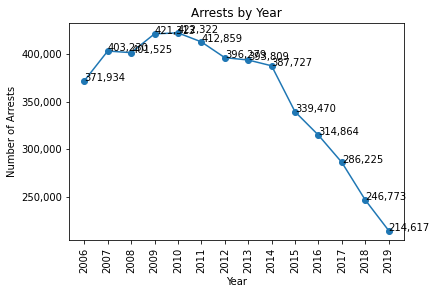

In [418]:
fig, ax = plt.subplots()
ax.plot(df_arrests_year.arrest_year, df_arrests_year.total_arrests, marker='o')
ax.set_xlabel("Year")
ax.set_ylabel("Number of Arrests")
ax.set_title("Arrests by Year")
plt.xticks([x for x in df_arrests_year.arrest_year])
plt.xticks(rotation = 90)

#for i,j in df_arrests_year.items():
#    ax.annotate(j, xy=(i,j))

for i,j in zip(df_arrests_year.arrest_year, df_arrests_year.total_arrests):
    ax.annotate(format(j,','), xy=(i,j))

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, p: format(int(y), ',')))   

plt.show()

# ? How can I make this neater?

### Arrests by Year Percentage Change

In [419]:
df_arrests_year_pc = df.groupby('arrest_year', as_index=False)
df_arrests_year_pc = df_arrests_year_pc.size()
df_arrests_year_pc.rename(columns={'size':'total_arrests'}, inplace=True)
df_arrests_year_pc['change'] = round(df_arrests_year_pc.total_arrests.div(df_arrests_year_pc.total_arrests.shift(1))-1,2)
df_arrests_year_pc

,arrest_year,total_arrests,change
0,2006,371934,NaN
1,2007,403230,0.08
2,2008,401525,-0.00
3,2009,421313,0.05
4,2010,422322,0.00
5,2011,412859,-0.02
6,2012,396279,-0.04
7,2013,393809,-0.01
8,2014,387727,-0.02
9,2015,339470,-0.12


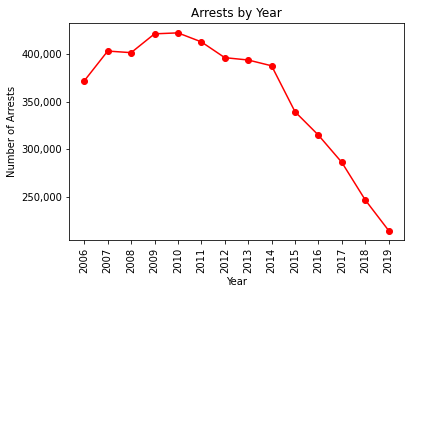

In [425]:
fig, ax = plt.subplots()
ax.plot(df_arrests_year_pc.arrest_year, df_arrests_year_pc.total_arrests, marker='o', color='red')
ax.set_xlabel("Year")
ax.set_ylabel("Number of Arrests")
ax.set_title("Arrests by Year")
plt.xticks([x for x in df_arrests_year_pc.arrest_year])
plt.xticks(rotation = 90)

#for i,j in df_arrests_year.items():
#    ax.annotate(j, xy=(i,j))

for i,j in zip(df_arrests_year_pc.arrest_year, df_arrests_year_pc.change):
    ax.annotate(j, xy=(i,j))

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, p: format(int(y), ',')))   

plt.show()

# ? Where are the labels?

### Drug Arrests by Year

In [421]:
df_drugs_year = df[df['category'] == 'DRUGS']
df_drugs_year = df_drugs_year.groupby('arrest_year', as_index=False)
df_drugs_year = df_drugs_year.size()
df_drugs_year.rename(columns={'size':'total_arrests'}, inplace=True)
df_drugs_year

,arrest_year,total_arrests
0,2006,96871
1,2007,110510
2,2008,106998
3,2009,107260
4,2010,105022
5,2011,103901
6,2012,89451
7,2013,76711
8,2014,71539
9,2015,55217


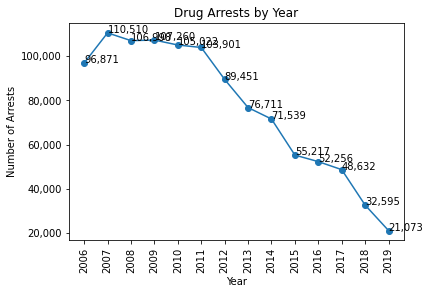

In [433]:
fig, ax = plt.subplots()
ax.plot(df_drugs_year.arrest_year, df_drugs_year.total_arrests, marker='o')
ax.set_xlabel("Year")
ax.set_ylabel("Number of Arrests")
ax.set_title("Drug Arrests by Year")
plt.xticks([x for x in df_drugs_year.arrest_year])
plt.xticks(rotation = 90)

#for i,j in df_arrests_year.items():
#    ax.annotate(j, xy=(i,j))

for i,j in zip(df_drugs_year.arrest_year, df_drugs_year.total_arrests):
    ax.annotate(format(j, ','), xy=(i,j))

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, p: format(int(y), ',')))   

plt.show()

# ? Where are the labels?

### Arrests by Month and Year

In [440]:
df_arrests_year_month = df.groupby(['arrest_year','arrest_month'], as_index=False)
df_arrests_year_month = df_arrests_year_month.size()
df_arrests_year_month.rename(columns={'size':'total_arrests'}, inplace=True)
df_arrests_year_month

,arrest_year,arrest_month,total_arrests
0,2006,1,31161
1,2006,2,28962
2,2006,3,34014
3,2006,4,30636
4,2006,5,32368
...,...,...,...
163,2019,8,18083
164,2019,9,16656
165,2019,10,17469
166,2019,11,15546


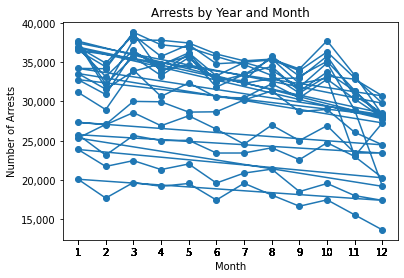

In [441]:
fig, ax = plt.subplots()
ax.plot(df_arrests_year_month.arrest_month, df_arrests_year_month.total_arrests, marker='o')
ax.set_xlabel("Month")
ax.set_ylabel("Number of Arrests")
ax.set_title("Arrests by Year and Month")
plt.xticks([x for x in df_arrests_year_month.arrest_month])

#for i,j in df_arrests_year.items():
#    ax.annotate(j, xy=(i,j))

#for i,j in zip(df_arrests_year_month.arrest_year, df_arrests_year_month.total_arrests):
#    ax.annotate(format(j, ','), xy=(i,j))

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, p: format(int(y), ',')))   

plt.show()

In [334]:
df_test_data = []
for i,j in zip(df_arrests_year.index, df_arrests_year.values):
    df_test_data.append([i,j])
df_test_data

[[2006, 371934],
 [2007, 403230],
 [2008, 401525],
 [2009, 421313],
 [2010, 422322],
 [2011, 412859],
 [2012, 396279],
 [2013, 393809],
 [2014, 387727],
 [2015, 339470],
 [2016, 314864],
 [2017, 286225],
 [2018, 246773],
 [2019, 214617]]

In [335]:
df_test = pd.DataFrame(
[[2006, 371934],
 [2007, 403230],
 [2008, 401525],
 [2009, 421313],
 [2010, 422322],
 [2011, 412859],
 [2012, 396279],
 [2013, 393809],
 [2014, 387727],
 [2015, 339470],
 [2016, 314864],
 [2017, 286225],
 [2018, 246773],
 [2019, 214617]],
columns=['year', 'arrests']
)
df_test

,year,arrests
0,2006,371934
1,2007,403230
2,2008,401525
3,2009,421313
4,2010,422322
5,2011,412859
6,2012,396279
7,2013,393809
8,2014,387727
9,2015,339470


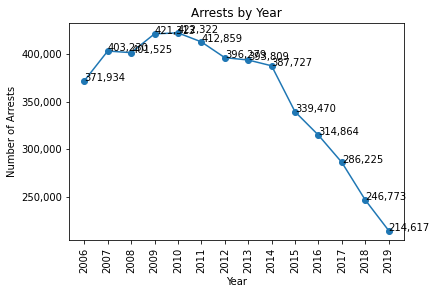

In [336]:
fig, ax = plt.subplots()
ax.plot(df_test.year, df_test.arrests, marker='o')
ax.set_xlabel("Year")
ax.set_ylabel("Number of Arrests")
ax.set_title("Arrests by Year")
plt.xticks([x for x in df_test.year])
plt.xticks(rotation = 90)

#for i,j in zip(df_test.year, df_test.arrests):
#    ax.annotate(j, xy=(i,j))

for i,j in zip(df_test.year, df_test.arrests):
    ax.annotate(format(j, ','), xy=(i,j))

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)   

plt.show()

ax.figure.savefig("/Users/amit/Desktop/sample.png", bbox_inches='tight', dpi=150)